In [1]:
from pylab import plot, show, grid, axis, xlabel, ylabel, title
import pandas as pd
from math import sqrt
from scipy.stats import norm
import numpy as np
import scipy.stats

### Brownian Motion Function

In [2]:
def brownian(x0, n, dt, delta, out=None):

    x0 = np.asarray(x0)

    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    r = norm.rvs(size=x0.shape + (n,), scale=delta*sqrt(dt))

    # If `out` was not given, create an output array.
    if out is None:
        out = np.empty(r.shape)

    # This computes the Brownian motion by forming the cumulative sum of
    # the random samples. 
    np.cumsum(r, axis=-1, out=out)

    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)

    return out

### Brownian Motion Parameters and Visualization

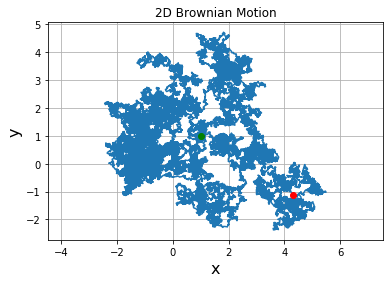

In [3]:
# The Wiener process parameter.
delta = 0.2
# Total time.
T = 1000.0
# Number of steps.
N = 50000
# Time step size
dt = T/N
# Initial values of x.
x = np.empty((2,N+1))
x[:, 0] = 1.0

brownian(x[:,0], N, dt, delta, out=x[:,1:])

# Plot the 2D trajectory.
plot(x[0],x[1])

# Mark the start and end points.
plot(x[0,0],x[1,0], 'go')
plot(x[0,-1], x[1,-1], 'ro')

# More plot decorations.
title('2D Brownian Motion')
xlabel('x', fontsize=16)
ylabel('y', fontsize=16)
axis('equal')
grid(True)
show()

### Simulation
#### Since the motion is (almost) continious probability of y = 0 is (almost) 0.
#### Selecting the first point that satisfies y <= 0 seems like a good approximation.
#### 50000 steps may not be enough for the partical to intersect the x axis. These cases are discarded.
#### Increasing the number of steps decreases the chance of this happening, but increases the computation time.

In [14]:
total = 0
count = 0
x_values = []
for i in range(100000):
    brownian(x[:,0], N, dt, delta, out=x[:,1:])
    x_intersect_index = np.argmax(x[1]<=0)
    if x_intersect_index != 0:
        total += 1
        x_value = x[0][x_intersect_index]
        if x_value < 0:
            count += 1
        x_values.append(x_value)
print(f'The probabality is {count/total}')

The probabality is 0.21871776652073258


#### Function to calculate confidence intervals

In [15]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

#### Transform the x values to binary values in order to be suitable for the function above
#### 1 if x < 0, 0 if not

In [16]:
x_bin = [1 if x < 0 else 0 for x in x_values]

In [17]:
mean_confidence_interval(x_bin)

(0.21871776652073258, 0.21597486675812488, 0.22146066628334027)

#### With %95 confidence, we can say that the probability is between 0.21522571477658334 and 0.2207034441575931

### Prepare the data for distribution calculations

In [18]:
xs = np.asarray(x_values, dtype=np.float32)

In [19]:
x_dist = pd.DataFrame(columns=['T','count'])
for i in [x * 0.1 for x in range(-100, 100)]:
    x_count = (xs < i).sum()
    x_dist = x_dist.append({'T':i ,'count':x_count/total}, ignore_index=True)
    j = i

### Cululative Probability Distribution Function

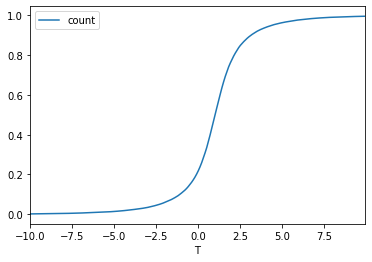

In [20]:
x_dist.set_index('T').plot()

### Probability Distribution Function

In [21]:
x_pdf = x_dist.set_index('T')
x_pdf['old_count'] = x_dist.set_index('T').shift(1)
x_pdf['dist'] = x_pdf['count'] - x_pdf['old_count']

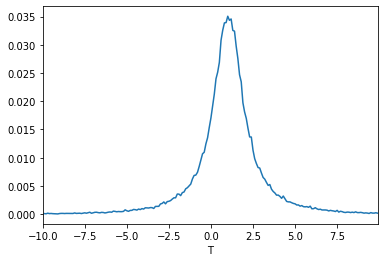

In [22]:
x_pdf['dist'].plot()

In [26]:
x_pdf[['dist']][x_pdf['dist'] == x_pdf['dist'].max()]

,dist
T,
1.0,0.035059


### The resulting graph shows a Gaussian distribution with mean T value at 1.
### The Brownian Motion is a random proccess so a normal distribution was expected.
### The offset starting point(1,1) caused the mean to shift to T=1.